## Compare the similarity

This compares the large scale data with training file


In [1]:
s3_prefix = "s3://aegovan-data/pubmed_asbtract/predictions_largescale_ppimulticlass-bert-f1-2021-05-10-10_2021-07-01/"
s3_predictions_above_threshold_file = "{}_summary/predictions_above_threshold.json".format(s3_prefix.rstrip("/"))

s3_trainfile = "s3://aegovan-data/processed_dataset/train_multiclass.json"
s3_testfile = "s3://aegovan-data/processed_dataset/test_multiclass.json"



In [2]:
import os, sys
sys.path.append("src")
import matplotlib.pyplot as plt

local_temp = "../temp"
local_temp_wk_dir = os.path.join( local_temp, "wk")

In [3]:
import shutil

def setup_dir(local_temp,local_temp_pred_dir, local_temp_wk_dir):
    shutil.rmtree(local_temp)
    os.makedirs(local_temp_pred_dir)
    os.makedirs(local_temp_wk_dir)



In [4]:
import boto3
import glob
from multiprocessing.dummy import Pool as ThreadPool
import argparse
import datetime 
import os


def upload_file(localpath, s3path):
        """
Uploads a file to s3
        :param localpath: The local path
        :param s3path: The s3 path in format s3://mybucket/mydir/mysample.txt
        """

        bucket, key = get_bucketname_key(s3path)

        if key.endswith("/"):
            key = "{}{}".format(key, os.path.basename(localpath))
        
        s3 = boto3.client('s3')
        
        s3.upload_file(localpath, bucket, key)

def get_bucketname_key(uripath):
    assert uripath.startswith("s3://")

    path_without_scheme = uripath[5:]
    bucket_end_index = path_without_scheme.find("/")

    bucket_name = path_without_scheme
    key = "/"
    if bucket_end_index > -1:
        bucket_name = path_without_scheme[0:bucket_end_index]
        key = path_without_scheme[bucket_end_index + 1:]

    return bucket_name, key


def download_file(s3path, local_dir):
    bucket, key = get_bucketname_key(s3path)
    
    s3 = boto3.client('s3')
    
    local_file = os.path.join(local_dir, s3path.split("/")[-1])
    

    s3.download_file(bucket, key, local_file)
    
    return local_file
    
def download_object(s3path):
    bucket, key = get_bucketname_key(s3path)
    
    s3 = boto3.client('s3')    

    s3_response_object = s3.get_object(Bucket=bucket, Key=key)
    object_content = s3_response_object['Body'].read()
    
    return len(object_content)



def list_files(s3path_prefix):
    assert s3path_prefix.startswith("s3://")
    assert s3path_prefix.endswith("/")
    
    bucket, key = get_bucketname_key(s3path_prefix)
    
   
   
    s3 = boto3.resource('s3')
    
    bucket = s3.Bucket(name=bucket)

    return ( (o.bucket_name, o.key) for o in bucket.objects.filter(Prefix=key))





def upload_files(local_dir, s3_prefix, num_threads=20):    
    input_tuples = ( (f,  s3_prefix) for f in glob.glob("{}/*".format(local_dir)))
    
    with ThreadPool(num_threads) as pool:
        pool.starmap(uploadfile, input_tuples)
    


def download_files(s3_prefix, local_dir, num_threads=20):    
    input_tuples = ( ("s3://{}/{}".format(s3_bucket,s3_key),  local_dir) for s3_bucket, s3_key in list_files(s3_prefix))
    
    with ThreadPool(num_threads) as pool:
        results = pool.starmap(download_file, input_tuples)
        
        

def download_objects(s3_prefix, num_threads=20):    
    s3_files = ( "s3://{}/{}".format(s3_bucket,s3_key) for s3_bucket, s3_key in list_files(s3_prefix))
    
    with ThreadPool(num_threads) as pool:
        results = pool.map(download_object, s3_files)
        
    return sum(results)/1024
        

def get_directory_size(start_path):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(start_path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            # skip if it is symbolic link
            if not os.path.islink(fp):
                total_size += os.path.getsize(fp)
    return total_size

def get_s3file_size(bucket, key):
    s3 = boto3.client('s3')
    response = s3.head_object(Bucket=bucket, Key=key)
    size = response['ContentLength']
    return size
    
def download_files_min_files(s3_prefix, local_dir, min_file_size=310, num_threads=20):    
    input_tuples = ( ("s3://{}/{}".format(s3_bucket,s3_key),  local_dir) for s3_bucket, s3_key in list_files(s3_prefix) if get_s3file_size(s3_bucket, s3_key) > min_file_size )
    
    with ThreadPool(num_threads) as pool:
        results = pool.starmap(download_file, input_tuples)
        



In [5]:
predictions_above_threshold_file = download_file(s3_predictions_above_threshold_file, local_temp_wk_dir)
trainfile = download_file(s3_trainfile, local_temp_wk_dir)
testfile = download_file(s3_testfile, local_temp_wk_dir)



In [6]:
import pandas as pd


def remove_training_records_save(trainfile, predictions_above_threshold_file):
    df_predictions_above_threshold = pd.read_json(predictions_above_threshold_file)
    df_trainfile = pd.read_json(trainfile)
    is_in_train = df_predictions_above_threshold["pubmedId"].isin(df_trainfile["pubmedId"])
    df = df_predictions_above_threshold[~is_in_train]
    
    df.to_json(predictions_above_threshold_file)

remove_training_records_save(trainfile, predictions_above_threshold_file)

In [7]:
from utils.ppi_multiclass_comparer import PpiMulticlassComparer
from utils.similarity_comparer import SimilarityComparer
import pandas as pd

def get_sim_scores(trainfile, predictions_above_threshold_file, n_gram):
    comparer =  PpiMulticlassComparer(comparer = SimilarityComparer(n_gram=n_gram))
    best_score, best_match = comparer.compare(trainfile, predictions_above_threshold_file)
    
    list_of_tuples = list(zip(best_score, best_match))
   
  
    df = pd.DataFrame(list_of_tuples,
                      columns = ['score', 'best_match'])
    
    return df
    
def plot_sim_scores(df, ax):
                    
    ax.set_ylim(0,1)

    ax.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False)

    ax.spines['bottom'].set_color('grey')
    ax.spines['top'].set_color('grey') 
    ax.spines['right'].set_color('grey')
    ax.spines['left'].set_color('grey')
        
    ax.violinplot(df,  showmeans=True )

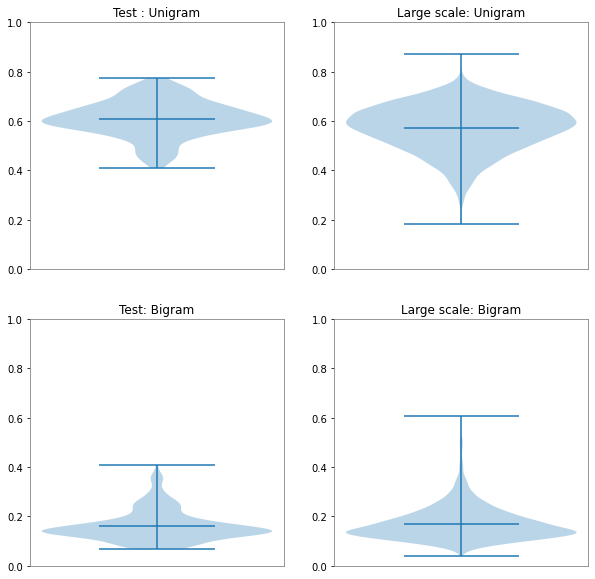

In [11]:
_,axes = plt.subplots(2,2, figsize=(10,10))

ax = axes[0][0]
ax.set_title("Test : Unigram")
plot_sim_scores(get_sim_scores(trainfile, testfile, n_gram=1)["score"], ax)


ax = axes[0][1]
ax.set_title("Large scale: Unigram")
plot_sim_scores(get_sim_scores(trainfile, predictions_above_threshold_file, n_gram=1)["score"], ax)



ax = axes[1][0]
ax.set_title("Test: Bigram")
plot_sim_scores(get_sim_scores(trainfile, testfile, n_gram=2)["score"], ax)


ax = axes[1][1]
ax.set_title("Large scale: Bigram")
plot_sim_scores(get_sim_scores(trainfile, predictions_above_threshold_file, n_gram=2)["score"], ax)

plt.savefig(os.path.join(local_temp_wk_dir, "Largescalesimilarity.pdf"), bbox_inches="tight")

In [9]:
df = get_sim_scores(trainfile, predictions_above_threshold_file, n_gram=1)

df.describe()

,score
count,5710.000000
mean,0.571260
std,0.094042
min,0.184999
25%,0.513234
50%,0.580736
75%,0.640494
max,0.870969
